<a href="https://colab.research.google.com/github/pranav033-ctrl/Pnuenmonia-Detection-Using-CNN-based-Pre-trained-Models/blob/main/AI%20Project%20MobileNet_acc_98_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
! pip install -q kaggle

In [18]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ppranav033","key":"f79e5cd731b148c905630224eed90f8b"}'}

In [20]:
! cp kaggle.json ~/.kaggle/

In [21]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [22]:
! kaggle datasets list

ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                      2022 Ukraine Russia War                            2KB  2022-04-14 11:06:51           8103        460  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease  Personal Key Indicators of Heart Disease           3MB  2022-02-16 10:18:03          13363        291  1.0              
datasets/ankanhore545/cost-of-living-index-2022                Cost of Living Index 2022                          4KB  2022-04-09 06:22:10           2650         50  0.8235294        
datasets/prasertk/best-tv-shows-of-all-time                    Best TV shows of 

In [23]:
!kaggle datasets download -d ppranav033/covidpneumonia

covidpneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
! unzip covidpneumonia.zip

Archive:  covidpneumonia.zip
replace Data/Test/Covid/COVID-1009.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/Test/Covid/COVID-1022.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [25]:
!pwd

/content


In [26]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, MobileNet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [27]:
base_model = MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [28]:
training_dir='./Data/Train/'
validation_dir='./Data/Valid/'
test_dir='./Data/Test/'

In [29]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 1377 files belonging to 2 classes.


In [30]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 11047 files belonging to 2 classes.


In [31]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 1384 files belonging to 2 classes.


In [32]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

In [33]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [34]:
x=base_model.output

x= data_augmentation(x)
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.6)(x)
# x= Dense(1024,activation='relu')(x) 
x= Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.6)(x)

preds=Dense(2,activation='softmax')(x)

In [35]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [36]:
# for layer in model.layers[:-8]:
#     layer.trainable=False

# for layer in model.layers[-8:]:
#     layer.trainable=True

In [37]:
base_model.trainable = False

In [38]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [39]:
len(model.trainable_variables)

8

In [40]:
initial_epochs = 20

In [41]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1)

Epoch 1/20
691/691 [==============================] - 54s 58ms/step - loss: 0.9919 - accuracy: 0.6548 - val_loss: 0.4520 - val_accuracy: 0.8374
Epoch 2/20
691/691 [==============================] - 39s 55ms/step - loss: 0.7044 - accuracy: 0.7489 - val_loss: 0.3771 - val_accuracy: 0.8786
Epoch 3/20
691/691 [==============================] - 39s 55ms/step - loss: 0.6124 - accuracy: 0.7798 - val_loss: 0.3562 - val_accuracy: 0.8873
Epoch 4/20
691/691 [==============================] - 38s 55ms/step - loss: 0.5583 - accuracy: 0.8021 - val_loss: 0.3402 - val_accuracy: 0.8923
Epoch 5/20
691/691 [==============================] - 40s 57ms/step - loss: 0.5160 - accuracy: 0.8171 - val_loss: 0.3342 - val_accuracy: 0.8974
Epoch 6/20
691/691 [==============================] - 38s 55ms/step - loss: 0.5016 - accuracy: 0.8160 - val_loss: 0.3280 - val_accuracy: 0.9010
Epoch 7/20
691/691 [==============================] - 39s 56ms/step - loss: 0.4796 - accuracy: 0.8249 - val_loss: 0.3271 - val_accuracy:

In [42]:
score = model.evaluate(test_ds, verbose = 1) 

87/87 [==============================] - 5s 49ms/step - loss: 0.2680 - accuracy: 0.9223


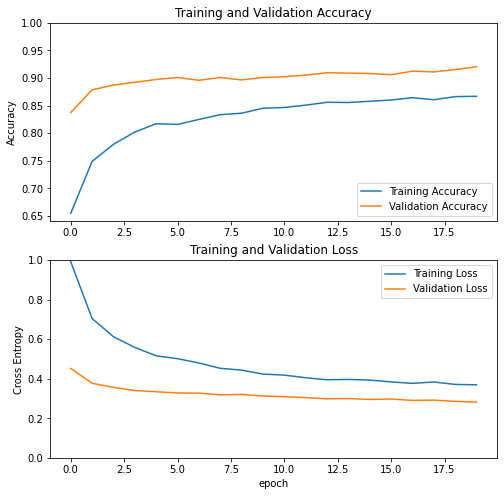

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
base_model.trainable = True

In [45]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 42

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  86


In [46]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [47]:
len(model.trainable_variables)

50

In [48]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 20/40
691/691 [==============================] - 70s 90ms/step - loss: 0.4645 - accuracy: 0.8239 - val_loss: 0.3108 - val_accuracy: 0.8996
Epoch 21/40
691/691 [==============================] - 61s 88ms/step - loss: 0.3497 - accuracy: 0.8795 - val_loss: 0.2625 - val_accuracy: 0.9212
Epoch 22/40
691/691 [==============================] - 61s 88ms/step - loss: 0.2947 - accuracy: 0.9044 - val_loss: 0.2350 - val_accuracy: 0.9371
Epoch 23/40
691/691 [==============================] - 61s 88ms/step - loss: 0.2534 - accuracy: 0.9256 - val_loss: 0.2020 - val_accuracy: 0.9501
Epoch 24/40
691/691 [==============================] - 61s 88ms/step - loss: 0.2265 - accuracy: 0.9374 - val_loss: 0.1933 - val_accuracy: 0.9545
Epoch 25/40
691/691 [==============================] - 61s 89ms/step - loss: 0.2041 - accuracy: 0.9489 - val_loss: 0.1797 - val_accuracy: 0.9617
Epoch 26/40
691/691 [==============================] - 61s 89ms/step - loss: 0.1907 - accuracy: 0.9534 - val_loss: 0.1694 - val_ac

In [49]:
score = model.evaluate(test_ds, verbose = 1) 

87/87 [==============================] - 4s 46ms/step - loss: 0.1147 - accuracy: 0.9811


In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

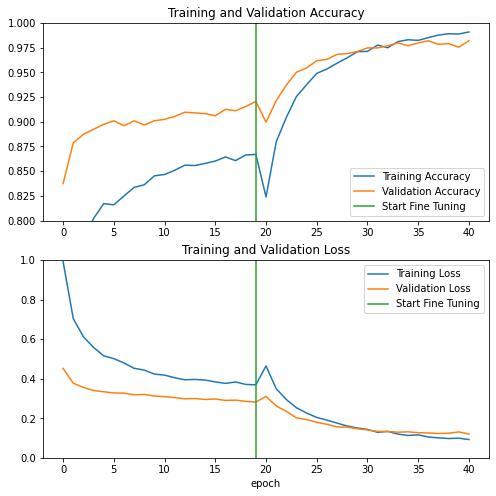

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
model.save('/')

INFO:tensorflow:Assets written to: /assets
